In [1]:
import sys
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

sys.path.append("./lib")

device = torch.device("cuda")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


### Step 1: Loading the dataset

See [Steam Genres](./steam_genres.ipynb) for more information.

In [2]:
import steam.loaders.genre_classification

from pathlib import Path

dataset, metadata = steam.loaders.genre_classification.load_for_multimodal(
    steam_games=Path("./data/steam/games.json"),
    top_n_by_popularity=100,
    prompt_template="USER: <image>\nWhat video game genres are on the image?\nASSISTANT:<assistant>"
)

dataset["train"].data.head()

,id,title,image,genres,text
1262,1118010,Monster Hunter World: Iceborne,images/1118010/ss_4d98c381f7038b0c0efe5e2425e2...,[Action],Action
979,1313140,Cult of the Lamb,images/1313140/ss_b26625d6f64a739ed1ddf832a5d2...,"[Action, Adventure, Indie, Strategy]","Action, Adventure, Indie, Strategy"
792,578080,PUBG: BATTLEGROUNDS,images/578080/ss_8814c071f0cce53821d8e1b1a96de...,"[Action, Adventure, Massively Multiplayer, Fre...","Action, Adventure, Massively Multiplayer, Free..."
1433,518790,theHunter: Call of the Wild™,images/518790/ss_39c535f3ea0805ba8f8cc58039c4b...,"[Adventure, Simulation, Sports]","Adventure, Simulation, Sports"
374,1966720,Lethal Company,images/1966720/ss_568d97dfa9d8d3128157d84c9437...,"[Action, Adventure, Indie, Early Access]","Action, Adventure, Indie, Early Access"


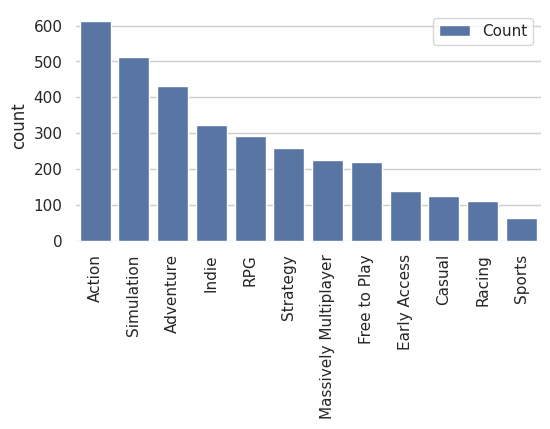

In [3]:
f, ax = plt.subplots(figsize=(6, 3))

sns.barplot(y="count", x="genres", data=metadata.genre_counts, label="Count")
sns.despine(left=True, bottom=True)
ax.set(xlabel="")
ax.tick_params(axis="x", rotation=90)

In [4]:
import typing
from transformers import AutoImageProcessor, CLIPImageProcessor, AutoTokenizer, PreTrainedTokenizerBase, LlavaForConditionalGeneration, BitsAndBytesConfig
from peft import LoraConfig, LoftQConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel

model_id = "llava-hf/llava-1.5-7b-hf"

# Set this to None if you want to train from scratch
checkpoint_name = None

image_processor = typing.cast(CLIPImageProcessor, AutoImageProcessor.from_pretrained(model_id))
tokenizer = typing.cast(PreTrainedTokenizerBase, AutoTokenizer.from_pretrained(
    model_id,
    use_fast=True,
))
tokenizer.padding_side = "left"

# We need to quantize the model quite a bit to train on a consumer, 12G GPU. 4-bit nf4 seems to work fine.
# You can also experiment with `LoftQ` (see below), but the loading the model was _very_ slow with it.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

base_model = typing.cast(LlavaForConditionalGeneration, LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,

))
base_model = prepare_model_for_kbit_training(base_model)

# LoftQ is not used for now because of performance problems
loftq_config = LoftQConfig(loftq_bits=4)
config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules="all-linear",
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)

if checkpoint_name is not None:
    model = PeftModel.from_pretrained(base_model, "./data/steam_genre_classifier/checkpoint-1000")
else:
    model = get_peft_model(base_model, config)

model.base_model.model.get_decoder().enable_input_require_grads()
model.print_trainable_parameters()
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 95,692,800 || all params: 7,159,119,872 || trainable%: 1.3366559257411468


PeftModel(
  (base_model): LoraModel(
    (model): LlavaForConditionalGeneration(
      (vision_tower): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
          (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
          )
          (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder): CLIPEncoder(
            (layers): ModuleList(
              (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPAttention(
                  (k_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1024, out_features

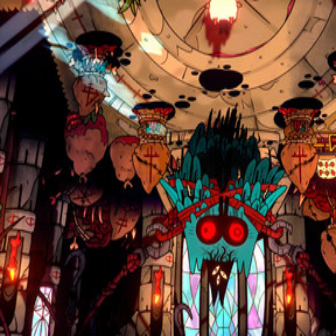

In [5]:
import numpy as np
import PIL.Image

from torchvision.transforms import v2

size = image_processor.size["height"] if "height" in image_processor.size else image_processor.size["shortest_edge"]
mean = typing.cast(list[float], image_processor.image_mean)
std = typing.cast(list[float], image_processor.image_std)

# We do some standard image dataset augmentation. As we can take multiple images from the same game, we add a random
# horizontal/vertical flip to hopefully make the model a bit more robust.
transform = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(size,size), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(p=0.1),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

dataset["train"].set_transform(transform)
dataset["train"].set_tokenizer(tokenizer)
dataset["test"].set_transform(transform)
dataset["test"].set_tokenizer(tokenizer)

# Denormalize the pixel values to see that the image is also correctly loaded
def inverse_transform(pixel_values: torch.Tensor) -> PIL.Image.Image:
    unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return PIL.Image.fromarray(unnormalized_image)

inverse_transform(dataset["train"][1]["pixel_values"])

In [6]:
from transformers import TrainingArguments, Trainer, IntervalStrategy
from torch.nn.utils.rnn import pad_sequence

def data_collator(batch: list[dict[str, torch.Tensor]]):
    """
    A data collator for preparing batches to be sent to a multimodal model for training. Performs minimal padding
    and tweaks the attention masks appropriately.
    """
    assert tokenizer.pad_token_id, "We need to pad the sequences to get them of the same length"

    # We can just stack the pixel values as the images were already resized
    pixel_values = torch.stack([item["pixel_values"] for item in batch])

    input_ids = [item["input_ids"] for item in batch]
    labels = [item["labels"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]

    # We can pad the input ids with the padding token. We are only padding up to the longest input_ids tensor so we
    # waste as little space as possible. It makes no sense to pad to the model's potential maximum length, as all of
    # those tokens will be masked for attention and ignored for loss.
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)

    # For the labels, we want to pad them with -100 so that they are ignored when we calculate the loss
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=-100)

    # And we make sure that padding tokens are masked out for attention
    padded_attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return { "pixel_values": pixel_values, "labels": padded_labels, "input_ids": padded_input_ids, "attention_mask": padded_attention_mask }

training_args = TrainingArguments(
    output_dir="./data/steam_genre_classifier",
    remove_unused_columns=False,
    evaluation_strategy=IntervalStrategy.STEPS,
    save_strategy=IntervalStrategy.STEPS,
    save_total_limit=10,
    eval_steps=1000,
    save_steps=1000,
    learning_rate=5e-5,
    weight_decay=0.01,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=20,
    label_names=["labels"],
    tf32=True,
    bf16=True,
    optim="adamw_bnb_8bit",
    gradient_checkpointing=False,
    # Comment these out when testing new models to check for CUDA OOM errors quicker, but for debugging, it just makes things more difficult
    # torch_compile=True,
    # torch_compile_backend="inductor",
    # torch_compile_mode="reduce-overhead"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

In [ ]:
trainer.train()

In [ ]:
from transformers import LlavaProcessor

processor = LlavaProcessor(tokenizer=tokenizer, image_processor=image_processor)

for i in range(10):
    image = dataset["test"].load_raw_image(i)
    prompt = dataset["test"].prompt_template.replace("<assistant>", "")
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)
    generated_ids = model.generate(**inputs, max_new_tokens=28)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    display(image)
    print(generated_text)